In [ ]:
!pip install optuna shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import sys

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
import optuna
import shap


In [ ]:
train_df = pd.read_csv('train.csv')

In [ ]:
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
train_df.dtypes

,0
date,object
store,int64
item,int64
sales,int64


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
store,913000.0,5.500000,2.872283,1.0,3.0,5.5,8.0,10.0
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


In [ ]:
train_df.isna().sum()

,0
date,0
store,0
item,0
sales,0


In [ ]:
train_df.duplicated().sum()

0

In [ ]:

train_df['date'] = pd.to_datetime(train_df['date'])

In [ ]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.set_index('date', inplace=True)
train_df.sort_values(by=['date', 'store', 'item'], inplace=True)
train_df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-01,1,2,33
2013-01-01,1,3,15
2013-01-01,1,4,10
2013-01-01,1,5,11


# Feature Engineering and EDA

### Creating Date time Features

In [ ]:
df_date = train_df.copy()

In [ ]:
df_date['day_of_week'] = df_date.index.dayofweek
df_date['quarter'] = df_date.index.quarter
df_date['month'] = df_date.index.month
df_date['year'] = df_date.index.year
df_date['day_of_year'] = df_date.index.dayofyear
df_date['day_of_month'] = df_date.index.day
df_date['week_of_year'] = df_date.index.isocalendar().week.astype(float)
df_date['is_wknd'] = df_date.index.weekday // 4
df_date['is_month_start'] = df_date.index.is_month_start.astype(int)
df_date['is_month_end'] = df_date.index.is_month_end.astype(int)
df_date['is_quarter_end'] = df_date.index.is_quarter_end.astype(int)
df_date['is_year_start'] = df_date.index.is_year_start.astype(int)
df_date['is_year_end'] = df_date.index.is_year_end.astype(int)

In [ ]:
df_date

,store,item,sales,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,is_wknd,is_month_start,is_month_end,is_quarter_end,is_year_start,is_year_end
date,,,,,,,,,,,,,,,,
2013-01-01,1,1,13,1,1,1,2013,1,1,1.0,0,1,0,0,1,0
2013-01-01,1,2,33,1,1,1,2013,1,1,1.0,0,1,0,0,1,0
2013-01-01,1,3,15,1,1,1,2013,1,1,1.0,0,1,0,0,1,0
2013-01-01,1,4,10,1,1,1,2013,1,1,1.0,0,1,0,0,1,0
2013-01-01,1,5,11,1,1,1,2013,1,1,1.0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,10,46,70,6,4,12,2017,365,31,52.0,1,0,1,1,0,1
2017-12-31,10,47,22,6,4,12,2017,365,31,52.0,1,0,1,1,0,1
2017-12-31,10,48,60,6,4,12,2017,365,31,52.0,1,0,1,1,0,1


## Lag Features

In [ ]:
df_lag = train_df.copy()
df_lag_log = train_df.copy()
df_lag_log['sales'] = np.log1p(df_lag_log['sales'])

In [ ]:
df_lag['sales_lag_91'] = df_lag.groupby(['store', 'item'])['sales'].shift(91)
df_lag['sales_lag_98'] = df_lag.groupby(['store', 'item'])['sales'].shift(98)
df_lag['sales_lag_105'] = df_lag.groupby(['store', 'item'])['sales'].shift(105)
df_lag['sales_lag_112'] = df_lag.groupby(['store', 'item'])['sales'].shift(112)
df_lag['sales_lag_119'] = df_lag.groupby(['store', 'item'])['sales'].shift(119)
df_lag['sales_lag_126'] = df_lag.groupby(['store', 'item'])['sales'].shift(126)
df_lag['sales_lag_182'] = df_lag.groupby(['store', 'item'])['sales'].shift(182)
df_lag['sales_lag_364'] = df_lag.groupby(['store', 'item'])['sales'].shift(364)
df_lag['sales_lag_546'] = df_lag.groupby(['store', 'item'])['sales'].shift(546)
df_lag['sales_lag_728'] = df_lag.groupby(['store', 'item'])['sales'].shift(728)

In [ ]:
df_lag_log['sales_lag_91'] = df_lag_log.groupby(['store', 'item'])['sales'].shift(91)
df_lag_log['sales_lag_98'] = df_lag_log.groupby(['store', 'item'])['sales'].shift(98)
df_lag_log['sales_lag_105'] = df_lag_log.groupby(['store', 'item'])['sales'].shift(105)
df_lag_log['sales_lag_112'] = df_lag_log.groupby(['store', 'item'])['sales'].shift(112)
df_lag_log['sales_lag_119'] = df_lag_log.groupby(['store', 'item'])['sales'].shift(119)
df_lag_log['sales_lag_126'] = df_lag_log.groupby(['store', 'item'])['sales'].shift(126)
df_lag_log['sales_lag_182'] = df_lag_log.groupby(['store', 'item'])['sales'].shift(182)
df_lag_log['sales_lag_364'] = df_lag_log.groupby(['store', 'item'])['sales'].shift(364)
df_lag_log['sales_lag_546'] = df_lag_log.groupby(['store', 'item'])['sales'].shift(546)
df_lag_log['sales_lag_728'] = df_lag_log.groupby(['store', 'item'])['sales'].shift(728)

In [ ]:
df_lag

,store,item,sales,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
date,,,,,,,,,,,,,
2013-01-01,1,1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,2,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,3,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,5,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,10,46,70,67.0,92.0,82.0,102.0,93.0,96.0,98.0,71.0,105.0,51.0
2017-12-31,10,47,22,33.0,32.0,30.0,32.0,29.0,43.0,39.0,26.0,42.0,19.0
2017-12-31,10,48,60,75.0,85.0,80.0,99.0,78.0,95.0,107.0,53.0,101.0,52.0


In [ ]:
df_lag_log

,store,item,sales,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
date,,,,,,,,,,,,,
2013-01-01,1,1,2.639057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,2,3.526361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,3,2.772589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,4,2.397895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,5,2.484907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,10,46,4.262680,4.219508,4.532599,4.418841,4.634729,4.543295,4.574711,4.595120,4.276666,4.663439,3.951244
2017-12-31,10,47,3.135494,3.526361,3.496508,3.433987,3.496508,3.401197,3.784190,3.688879,3.295837,3.761200,2.995732
2017-12-31,10,48,4.110874,4.330733,4.454347,4.394449,4.605170,4.369448,4.564348,4.682131,3.988984,4.624973,3.970292


## Rolling Window Features

In [ ]:
df_roll = train_df.copy()
df_roll_log = train_df.copy()
df_roll_log['sales'] = np.log1p(df_roll_log['sales'])

In [ ]:
windows = [365, 546, 730]
df_roll['sales_roll_mean_365'] = df_roll.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 365, min_periods=30).mean())
df_roll['sales_roll_std_365'] = df_roll.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 365, min_periods=30).std())
df_roll['sales_roll_min_365'] = df_roll.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 365, min_periods=30).min())
df_roll['sales_roll_max_365'] = df_roll.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 365, min_periods=30).max())

df_roll['sales_roll_mean_546'] = df_roll.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 546, min_periods=30).mean())
df_roll['sales_roll_std_546'] = df_roll.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 546, min_periods=30).std())
df_roll['sales_roll_min_546'] = df_roll.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 546, min_periods=30).min())
df_roll['sales_roll_max_546'] = df_roll.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 546, min_periods=30).max())

df_roll['sales_roll_mean_730'] = df_roll.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 730, min_periods=30).mean())
df_roll['sales_roll_std_730'] = df_roll.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 730, min_periods=30).std())
df_roll['sales_roll_min_730'] = df_roll.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 730, min_periods=30).min())
df_roll['sales_roll_max_730'] = df_roll.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 730, min_periods=30).max())

In [ ]:
windows = [365, 546, 730]
df_roll_log['sales_roll_mean_365'] = df_roll_log.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 365, min_periods=30).mean())
df_roll_log['sales_roll_std_365'] = df_roll_log.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 365, min_periods=30).std())
df_roll_log['sales_roll_min_365'] = df_roll_log.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 365, min_periods=30).min())
df_roll_log['sales_roll_max_365'] = df_roll_log.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 365, min_periods=30).max())

df_roll_log['sales_roll_mean_546'] = df_roll_log.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 546, min_periods=30).mean())
df_roll_log['sales_roll_std_546'] = df_roll_log.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 546, min_periods=30).std())
df_roll_log['sales_roll_min_546'] = df_roll_log.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 546, min_periods=30).min())
df_roll_log['sales_roll_max_546'] = df_roll_log.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 546, min_periods=30).max())

df_roll_log['sales_roll_mean_730'] = df_roll_log.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 730, min_periods=30).mean())
df_roll_log['sales_roll_std_730'] = df_roll_log.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 730, min_periods=30).std())
df_roll_log['sales_roll_min_730'] = df_roll_log.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 730, min_periods=30).min())
df_roll_log['sales_roll_max_730'] = df_roll_log.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = 730, min_periods=30).max())

In [ ]:
df_roll

,store,item,sales,sales_roll_mean_365,sales_roll_std_365,sales_roll_min_365,sales_roll_max_365,sales_roll_mean_546,sales_roll_std_546,sales_roll_min_546,sales_roll_max_546,sales_roll_mean_730,sales_roll_std_730,sales_roll_min_730,sales_roll_max_730
date,,,,,,,,,,,,,,,
2013-01-01,1,1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,2,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,3,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,5,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,10,46,70,73.802740,18.830636,34.0,125.0,74.408425,18.246021,34.0,125.0,72.883562,18.602370,34.0,125.0
2017-12-31,10,47,22,28.120548,8.684123,6.0,56.0,27.992674,8.410344,6.0,56.0,27.531507,8.224539,6.0,56.0
2017-12-31,10,48,60,65.057534,16.799708,28.0,120.0,65.005495,16.045405,28.0,120.0,63.564384,16.041590,23.0,120.0


In [ ]:
df_roll_log

,store,item,sales,sales_roll_mean_365,sales_roll_std_365,sales_roll_min_365,sales_roll_max_365,sales_roll_mean_546,sales_roll_std_546,sales_roll_min_546,sales_roll_max_546,sales_roll_mean_730,sales_roll_std_730,sales_roll_min_730,sales_roll_max_730
date,,,,,,,,,,,,,,,
2013-01-01,1,1,2.639057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,2,3.526361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,3,2.772589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,4,2.397895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,5,2.484907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,10,46,4.262680,4.281565,0.263216,3.555348,4.836282,4.292284,0.252092,3.555348,4.836282,4.269174,0.263039,3.555348,4.836282
2017-12-31,10,47,3.135494,3.324743,0.314432,1.945910,4.043051,3.321762,0.311567,1.945910,4.043051,3.306861,0.306017,1.945910,4.043051
2017-12-31,10,48,4.110874,4.156825,0.264671,3.367296,4.795791,4.158765,0.253875,3.367296,4.795791,4.135464,0.258444,3.178054,4.795791


## Exponentially Weighted Mean Features

In [ ]:
df_ewm = train_df.copy()
df_ewm_log = train_df.copy()
df_ewm_log['sales'] = np.log1p(df_ewm_log['sales'])

In [ ]:
weights = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728]
for weight in weights:
  for lag in lags:
    df_ewm['sales_ewm_w_' + str(weight) + '_lag_' + str(lag)] = df_ewm.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=weight).mean())

In [ ]:
weights = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728]
for weight in weights:
  for lag in lags:
    df_ewm_log['sales_ewm_w_' + str(weight) + '_lag_' + str(lag)] = df_ewm_log.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=weight).mean())

# EDA

## Decomposition of the Time Series Components

<Figure size 640x480 with 0 Axes>

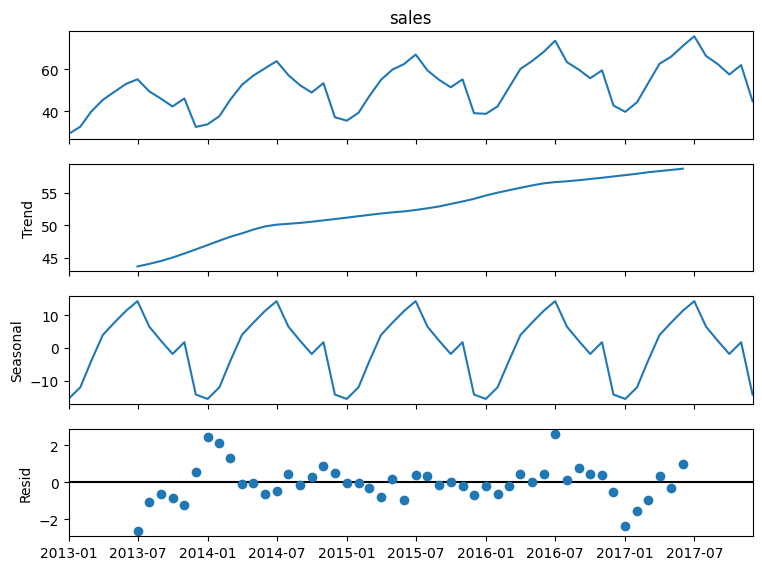

In [ ]:
montly_average_sales = train_df['sales'].resample('MS').mean()
decomposition = seasonal_decompose(montly_average_sales, model='additive')

fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(8, 6)

## Sales Distribution

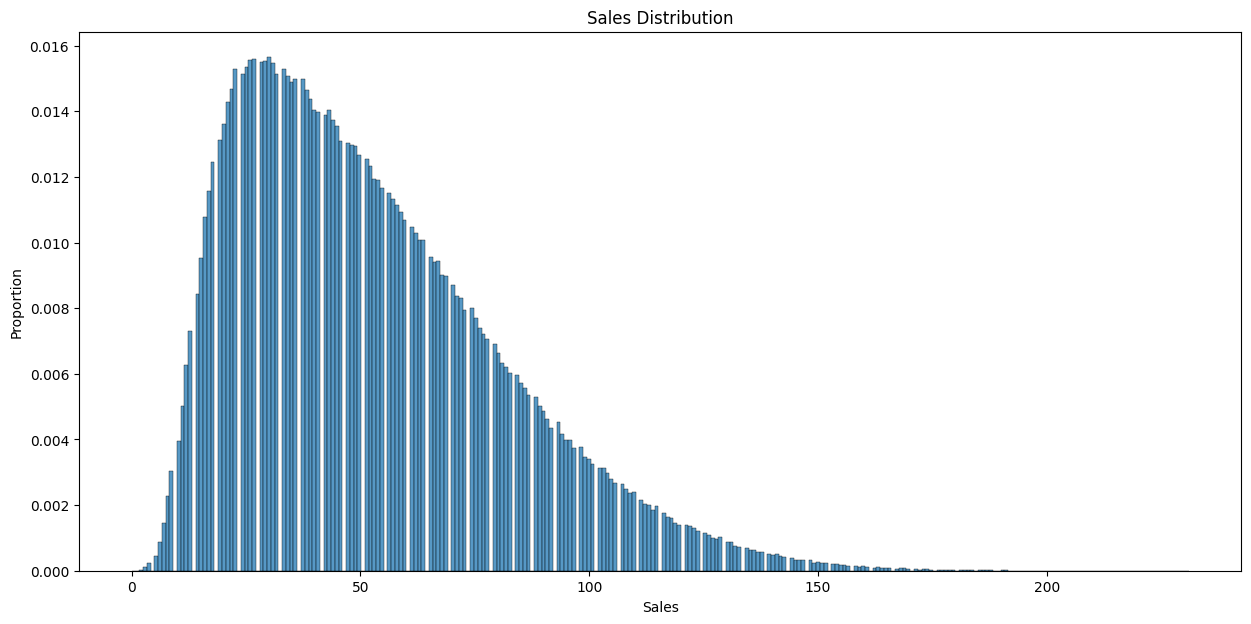

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(data=train_df, x='sales', stat='proportion')
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Proportion')
plt.show()

## Sales Distribution Over Time

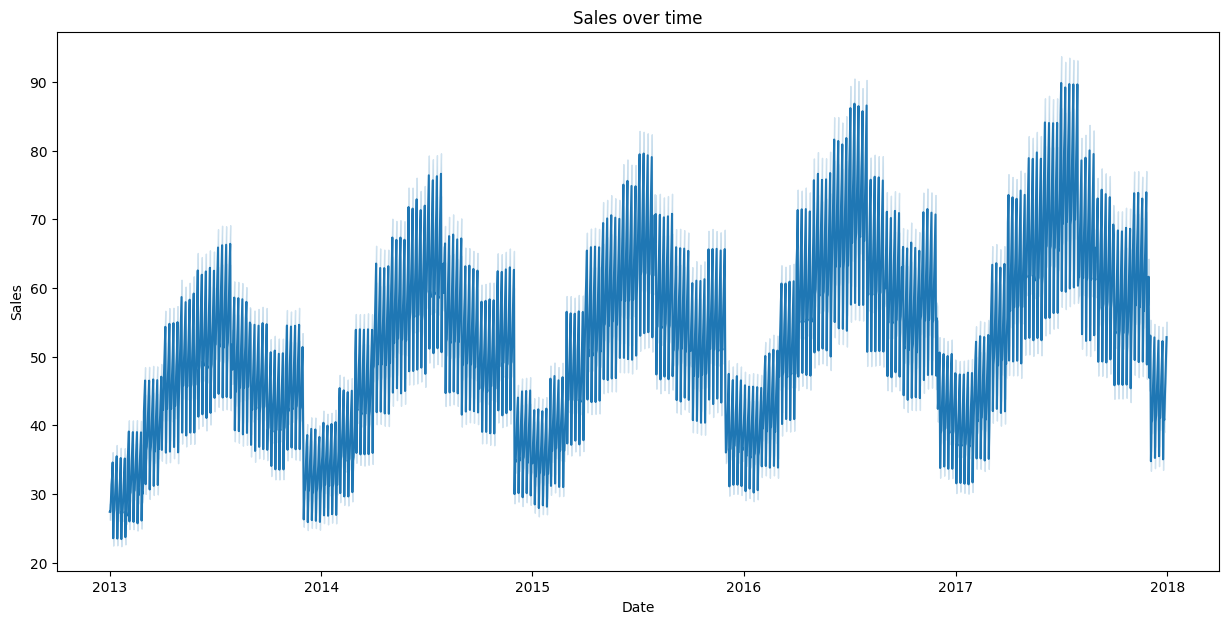

In [ ]:
plt.figure(figsize = (15, 7))
plt.title('Sales over time')
sns.lineplot(data=train_df, x='date', y='sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

## Sales Distribution over the months

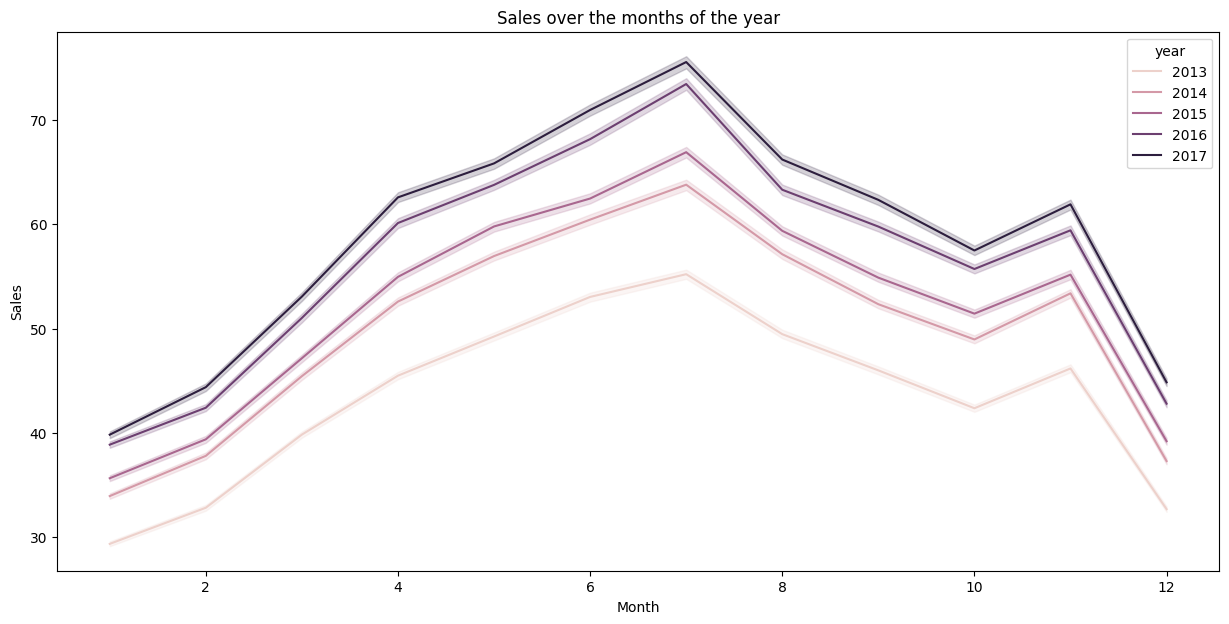

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=train_df, x='month', y='sales', hue='year')
plt.title('Sales over the months of the year')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

## Sales Distribution over the weeks of the year

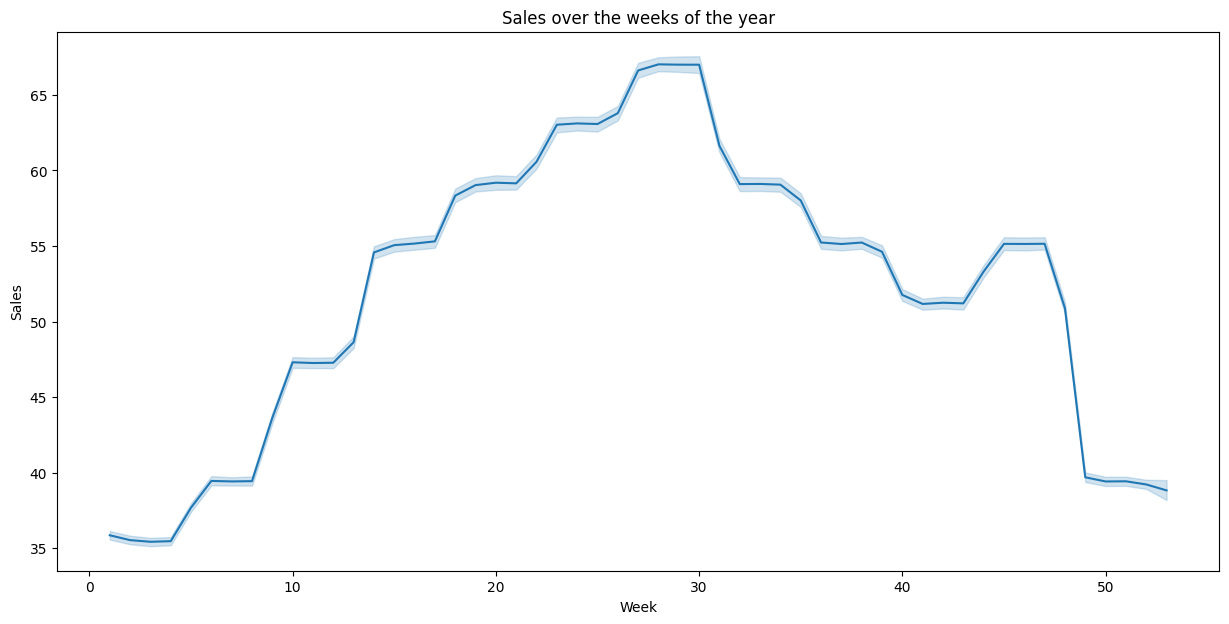

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=train_df, x='week_of_year', y='sales')
plt.title('Sales over the weeks of the year')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.show()

## Sales over the days of the week

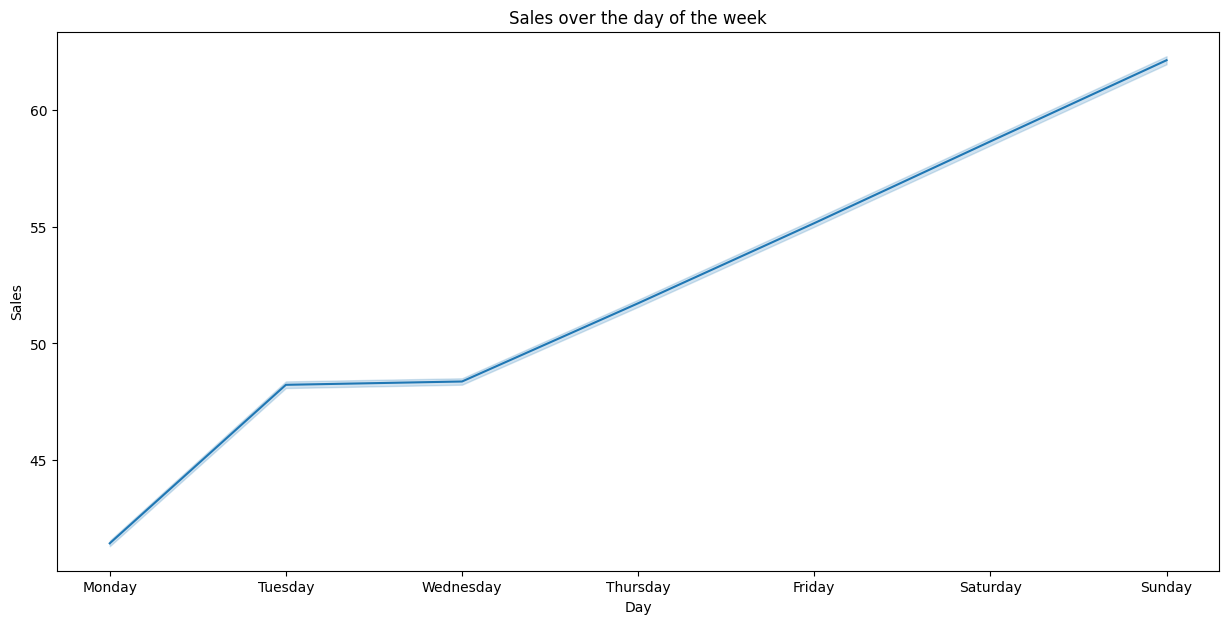

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=train_df, x='day_of_week', y='sales')
plt.title('Sales over the day of the week')
plt.xlabel('Day')
plt.xticks(range(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.ylabel('Sales')
plt.show()

## Sales Over the Months of the year

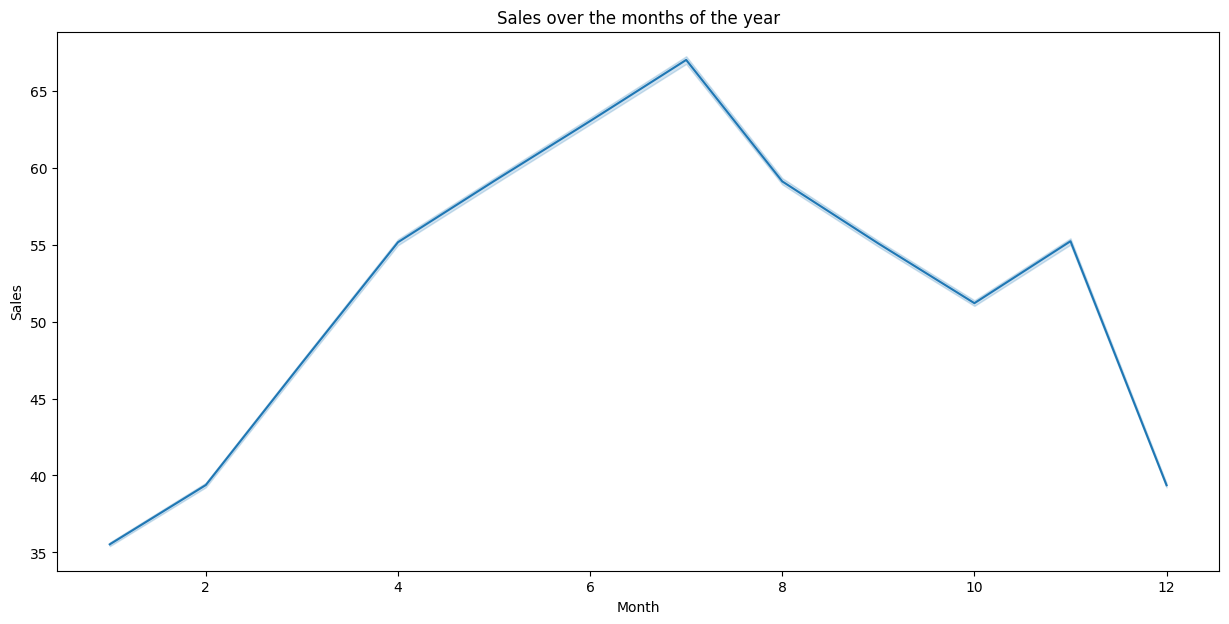

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=train_df, x='month', y='sales')
plt.title('Sales over the months of the year')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

## Which store had the highest sales over the years?

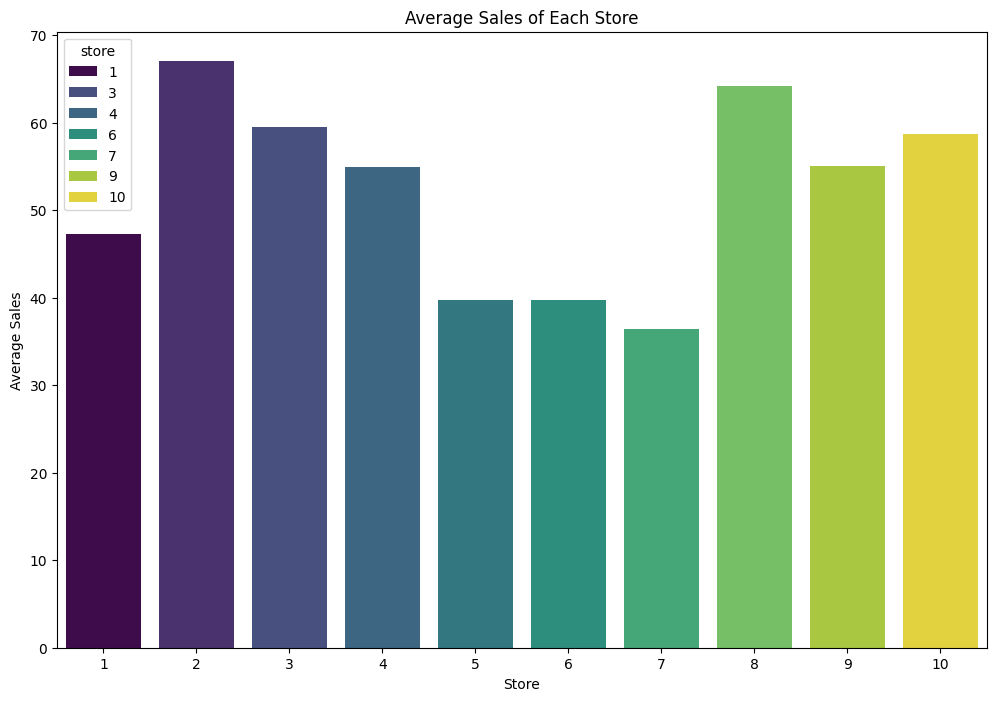

In [ ]:
average_sales = train_df.groupby('store')['sales'].mean().reset_index()

plt.figure(figsize=(12, 8))
plt.title('Average Sales of Each Store')
sns.barplot(data=average_sales, x='store', y='sales', errorbar='sd', palette='viridis', hue='store', legend=True)
plt.xlabel('Store')
plt.ylabel('Average Sales')
plt.show()

## Descriptive Statistics of Sales of each Store

In [ ]:
train_df.groupby('store').agg({'sales':['count', 'sum', 'mean', 'median', 'std', 'min', 'max']})

sales                                               
       count      sum       mean median        std min  max
store                                                      
1      91300  4315603  47.268379   44.0  24.006252   1  155
2      91300  6120128  67.033165   62.0  33.595810   3  231
3      91300  5435144  59.530602   55.0  29.974102   3  196
4      91300  5012639  54.902946   51.0  27.733097   4  186
5      91300  3631016  39.770164   37.0  20.365757   2  130
6      91300  3627670  39.733516   37.0  20.310451   0  134
7      91300  3320009  36.363735   34.0  18.684825   1  122
8      91300  5856169  64.142048   60.0  32.231751   4  204
9      91300  5025976  55.049025   51.0  27.832186   4  195
10     91300  5360158  58.709288   54.0  29.554994   3  187

## Top 10 Best Selling Items by Sales quantity

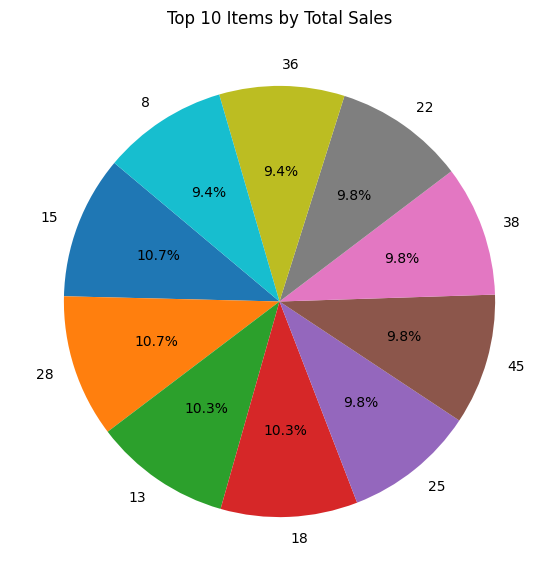

In [ ]:
top_10 = train_df.groupby('item')['sales'].sum().nlargest(10)

plt.figure(figsize=(10, 7))
plt.pie(top_10, labels=top_10.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Items by Total Sales')
plt.show()

## Descriptive Statistics of Items

In [ ]:
train_df.groupby('item').agg({'sales': ['count', 'sum', 'mean', 'median', 'std', 'min', 'max']})

sales                                               
      count      sum       mean median        std min  max
item                                                      
1     18260   401384  21.981599   21.0   8.468922   1   59
2     18260  1069564  58.574151   56.0  20.093015   9  150
3     18260   669087  36.642223   35.0  13.179441   7  104
4     18260   401907  22.010241   21.0   8.403898   0   66
5     18260   335230  18.358708   18.0   7.265167   1   50
6     18260  1068281  58.503888   56.0  20.174898  11  148
7     18260  1068777  58.531051   56.0  20.146002  11  141
8     18260  1405108  76.950055   74.0  26.130697  15  181
9     18260   938379  51.389869   49.5  17.790158   6  134
10    18260  1337133  73.227437   70.0  24.823725  14  175
11    18260  1271925  69.656353   67.0  23.744732  11  170
12    18260  1271534  69.634940   67.0  23.738663  12  170
13    18260  1539621  84.316594   81.0  28.311031  20  210
14    18260  1071531  58.681873   56.0  20.079860  12  152
15    18260  1607442  88.030778   85.0  29.522852  17  231
16    18260   468480  25.656079   25.0   9.603270   2   70
17    18260   602486  32.994852   32.0  11.967610   4   83
18    18260  1538876  84.275794   81.0  28.430621  18  208
19    18260   736892  40.355531   39.0  14.332645   5   99
20    18260   867641  47.515936   46.0  16.490487   9  127
21    18260   736190  40.317087   39.0  14.338006   7  109
22    18260  1469971  80.502245   78.0  27.118163  14  214
23    18260   534979  29.297864   28.0  10.819549   3   81
24    18260  1205975  66.044633   64.0  22.531555  14  156
25    18260  1473334  80.686418   78.0  27.238817  18  193
26    18260   869981  47.644085   46.0  16.723912   8  119
27    18260   402628  22.049726   21.0   8.461641   1   59
28    18260  1604713  87.881325   85.0  29.501781  16  206
29    18260  1271240  69.618839   67.0  23.635631  15  173
30    18260   736554  40.337021   39.0  14.363331   5  115
31    18260  1070845  58.644304   57.0  20.104705  10  159
32    18260   803107  43.981763   42.0  15.574556   5  119
33    18260  1270183  69.560953   67.0  23.718343  15  169
34    18260   469935  25.735761   25.0   9.617910   2   79
35    18260  1201541  65.801807   63.0  22.461990  12  168
36    18260  1406548  77.028916   74.0  26.067440  16  188
37    18260   534258  29.258379   28.0  10.771547   3   74
38    18260  1470330  80.521906   77.0  27.141799  15  188
39    18260   801311  43.883406   42.0  15.511550   7  112
40    18260   534094  29.249398   28.0  10.822959   3   74
41    18260   401759  22.002136   21.0   8.402470   2   60
42    18260   669925  36.688116   35.0  13.215112   5   96
43    18260   936635  51.294359   49.0  17.801008   9  126
44    18260   536811  29.398193   28.0  10.797738   3   78
45    18260  1471467  80.584173   78.0  27.318402  18  205
46    18260  1070764  58.639869   56.0  20.220879  11  150
47    18260   401781  22.003341   21.0   8.420102   2   61
48    18260   937703  51.352848   49.0  17.881917   8  130
49    18260   535663  29.335323   28.0  10.874788   3   77
50    18260  1203009  65.882202   63.0  22.416031  12  164

## Sales per Store

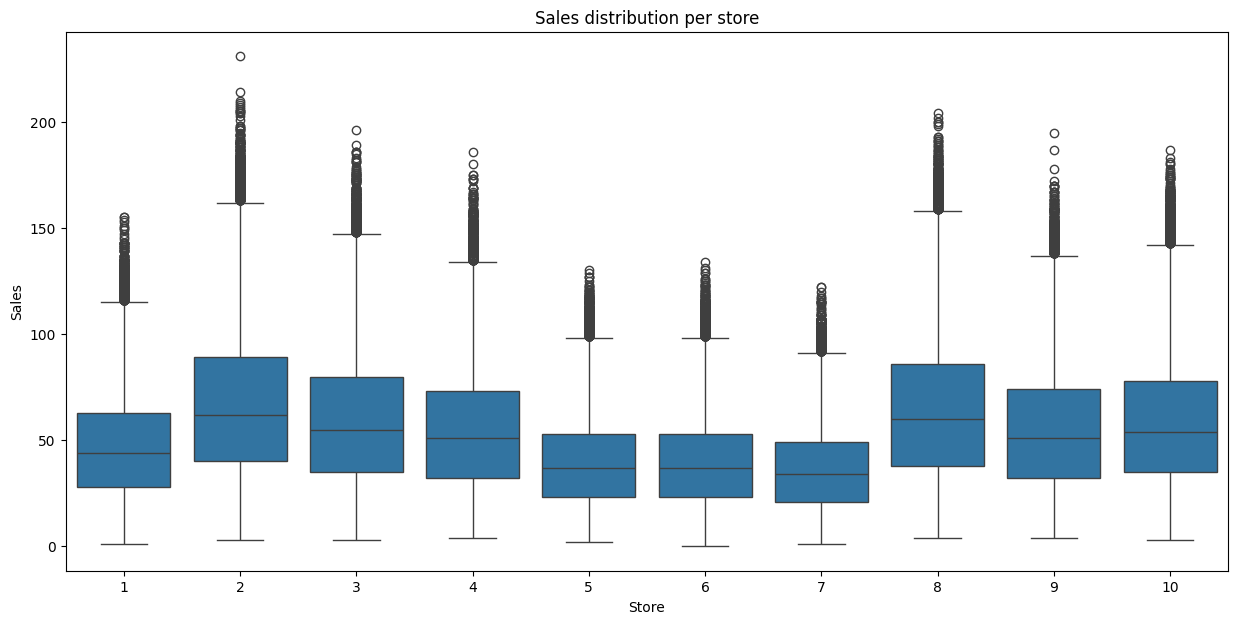

In [ ]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=train_df, x='store', y='sales')
plt.title('Sales distribution per store')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.show()

## Sales per Item

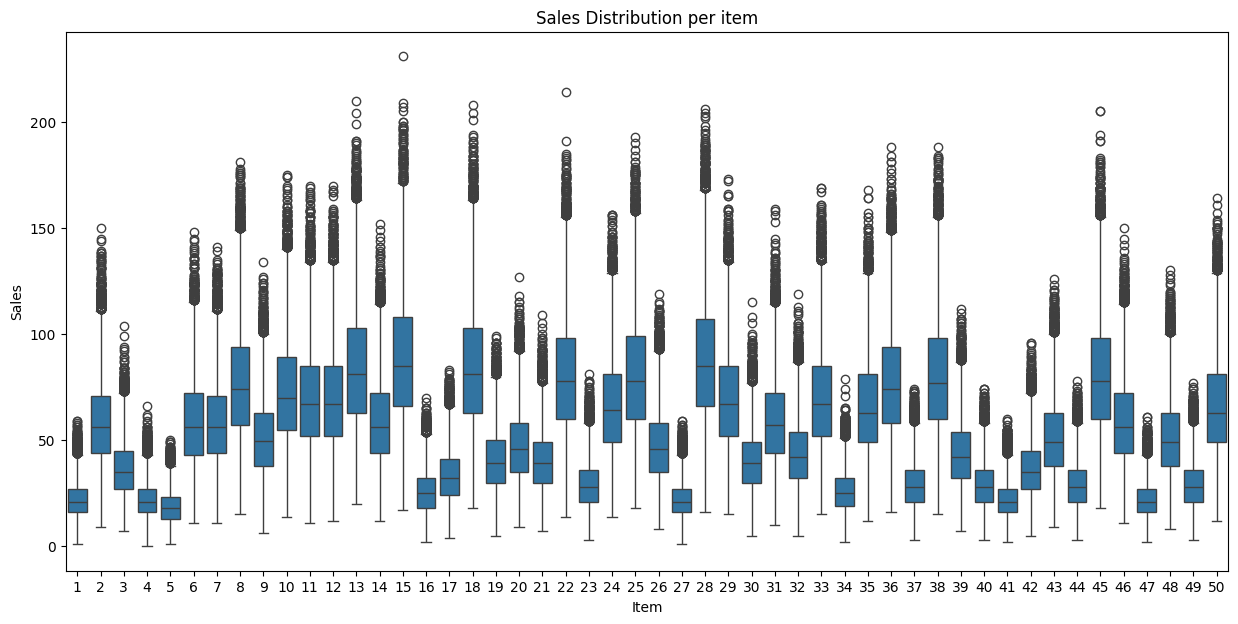

In [ ]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=train_df, x='item', y='sales')
plt.title('Sales Distribution per item')
plt.xlabel('Item')
plt.ylabel('Sales')
plt.show()

## Outlier Analysis

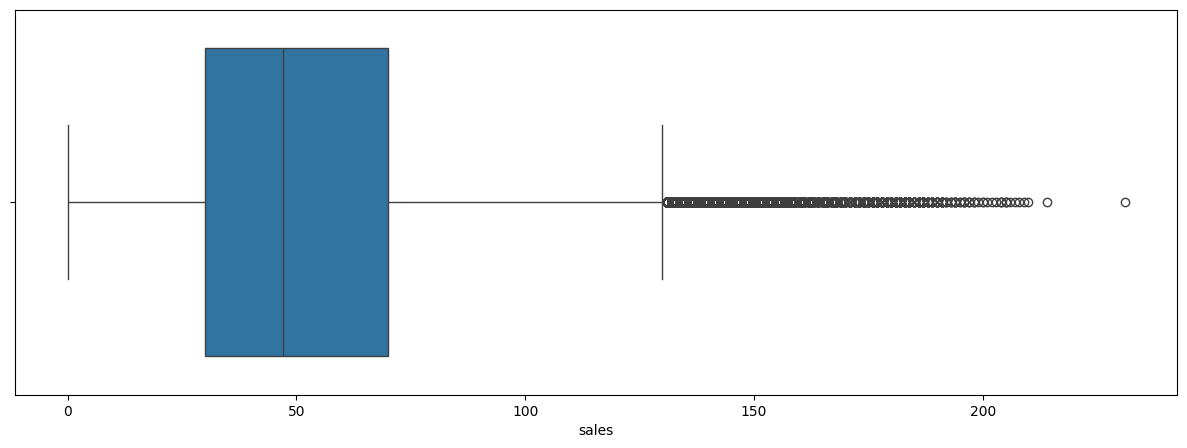

In [ ]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=train_df, x='sales')
plt.show()

In [ ]:
train_df.loc[train_df['sales'] == train_df['sales'].max(), ['sales', 'store', 'day_of_week', 'month']]

,sales,store,day_of_week,month
date,,,,
2017-07-02,231,2,6,7


In [ ]:
# lags = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728]
# acf = plot_acf(train_df['sales'], lags=lags)
# fig = plt.figure()

In [ ]:
# pacf = plot_pacf(train_df['sales'], lags=lags)
# fig = plt.figure()

# Modelling

#### Looking at the Distribution of the Sales its right skewed, I will apply a log transformation to it in order to make it more symmetric.

In [ ]:
train_df['sales_log'] = np.log1p(train_df['sales'])

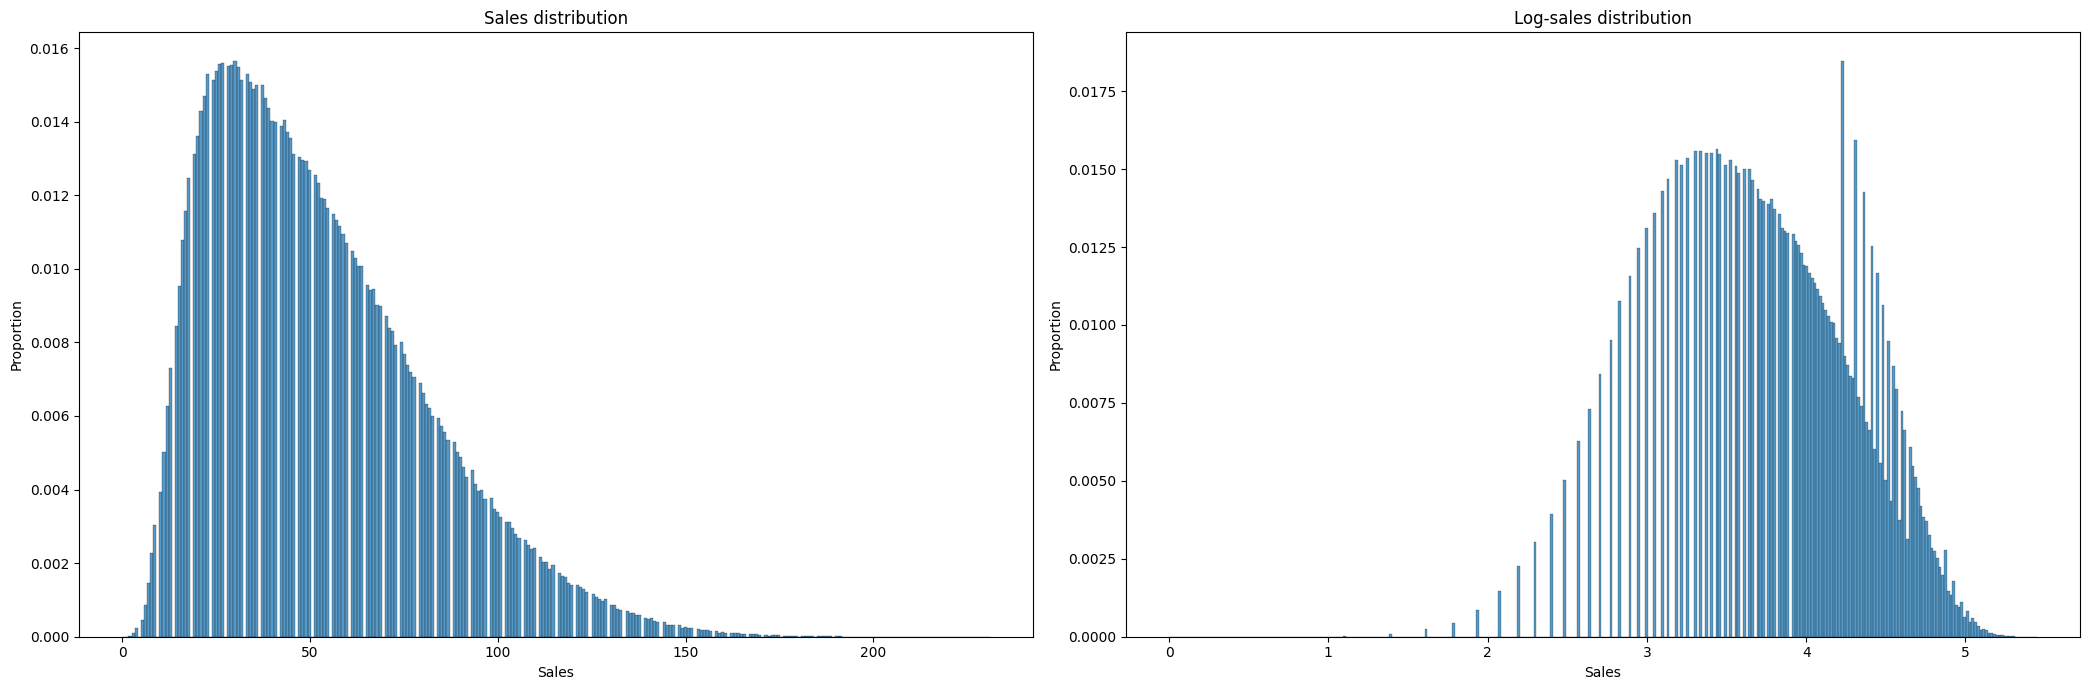

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))

ax0 = sns.histplot(data=train_df, x='sales', ax=ax[0], stat='proportion')
ax0.set_title('Sales distribution')
ax0.set_xlabel('Sales')
ax0.set_ylabel('Proportion')

ax1 = sns.histplot(data=train_df, x='sales_log', ax=ax[1], stat='proportion')
ax1.set_title('Log-sales distribution')
ax1.set_xlabel('Sales')
ax1.set_ylabel('Proportion')

plt.tight_layout()
plt.show()

## Train Test split

In [ ]:
def time_series_split(data, cutoff_date):
    '''
    Splits the time series data into train and test sets on a chronological order based on the cutoff date.

    Args:
    data (pandas.DataFrame): The time series data to be split.
    cutoff_date (str or datetime): The date that separates the training and test sets.

    Raises:
    CustomException: An error occurred during the time series split.

    Returns:
    tuple: A tuple containing two pandas.DataFrame objects, where the first one represents the training set
    with data before the cutoff date, and the second one represents the test set with data on and after the cutoff date.
    '''
    try:
        train = data.loc[data.index < cutoff_date]
        test = data.loc[data.index >= cutoff_date]
        return train, test

    except Exception as e:
      print(f"An error occurred: {e}")
      return None

In [ ]:
CUTOFF_DATE = '2017-09-30'
train, test = time_series_split(train_df, CUTOFF_DATE)
print(f'Train shape: {train.shape}. Train data goes from {train.index.min()} to {train.index.max()}.')
print(f'Test shape: {test.shape}. Train data goes from {test.index.min()} to {test.index.max()}.')

Train shape: (866500, 3). Train data goes from 2013-01-01 00:00:00 to 2017-09-29 00:00:00.
Test shape: (46500, 3). Train data goes from 2017-09-30 00:00:00 to 2017-12-31 00:00:00.


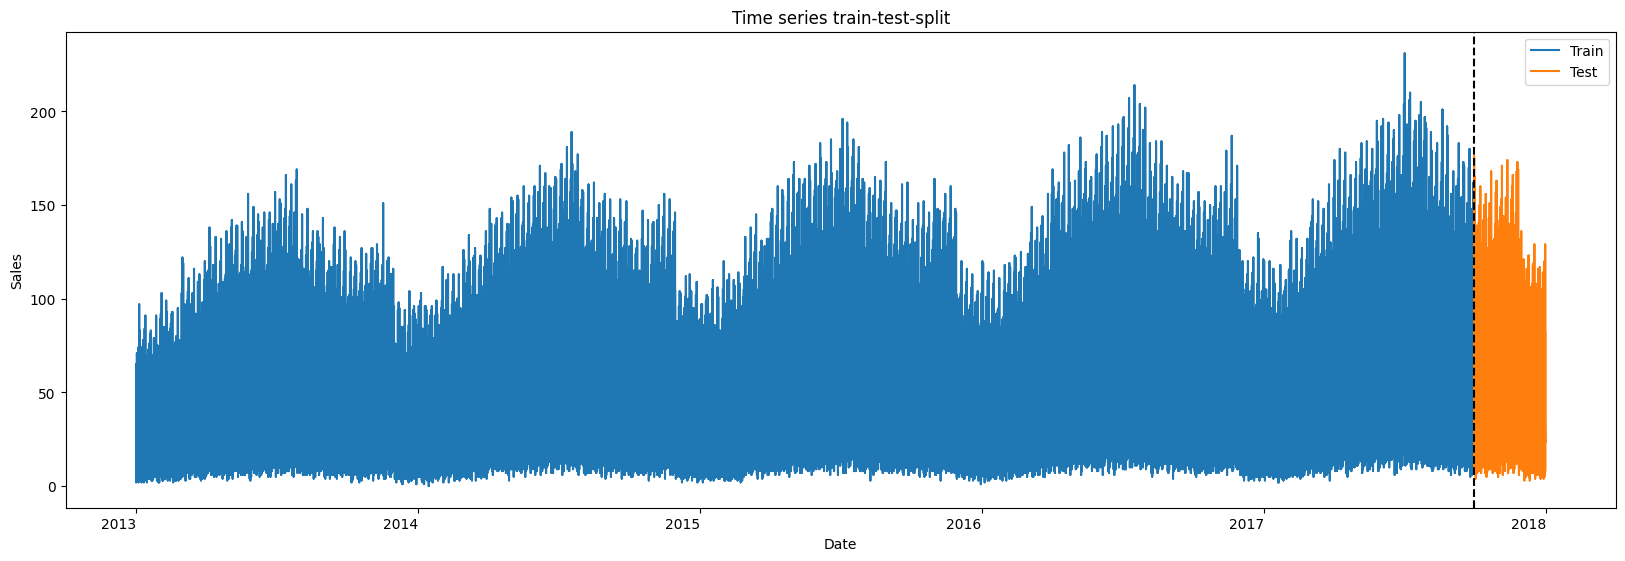

In [ ]:
figure, ax = plt.subplots(figsize=(20, 7))

train.plot(ax=ax, label='Train', y='sales')
test.plot(ax=ax, label='Test', y='sales')

ax.axvline(CUTOFF_DATE, color='black', ls='--')

plt.title('Time series train-test-split')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=0)
plt.legend()
plt.show()

In [ ]:
TEST_SIZE, GAP, TARGET = 1*93*50*10, 1*7*50*10, 'sales'

In [ ]:
def time_series_cv_report(data, target, test_size=None, gap=0, n_splits=5):
    '''
    Generates a time series cross-validation report and plot for the data.

    Args:
    data (pandas.DataFrame): The time series data.
    target (str): The target variable.
    test_size (int, optional): The size of the test set. Defaults to None.
    gap (int, optional): The gap between train and test sets. Defaults to 0.
    n_splits (int, optional): Number of splits for cross-validation. Defaults to 5.

    Raises:
    CustomException: An error occurred during the time series cross-validation report generation.
    '''
    try:
        # Get sklearn TimeSeriesSplit object to obtain train and validation chronological indexes at each fold.
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap)

        fig, axes = plt.subplots(n_splits, 1, figsize=(20, 8), sharex=True, sharey=True)

        for fold, (train_index, val_index) in enumerate(tscv.split(data)):
            # Print train and validation indexes at each fold.
            print('-'*30)
            print(f'Fold {fold}')
            print(f'Train: {train_index[0]} to {train_index[-1]}')
            print(f'Validation: {val_index[0]} to {val_index[-1]}')

            # Plot the Time Series Split at each fold.
            axes[fold].plot(data.index, data[target], label='Test Data', color='green')
            axes[fold].plot(data.iloc[train_index].index, data[target].iloc[train_index], label='Train')
            axes[fold].plot(data.iloc[val_index].index, data[target].iloc[val_index], label='Validation')

            axes[fold].set_title(f'Fold {fold} Time Series Split')
            axes[fold].legend(loc='upper left')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


------------------------------
Fold 0
Train: 0 to 630499
Validation: 634000 to 680499
------------------------------
Fold 1
Train: 0 to 676999
Validation: 680500 to 726999
------------------------------
Fold 2
Train: 0 to 723499
Validation: 727000 to 773499
------------------------------
Fold 3
Train: 0 to 769999
Validation: 773500 to 819999
------------------------------
Fold 4
Train: 0 to 816499
Validation: 820000 to 866499


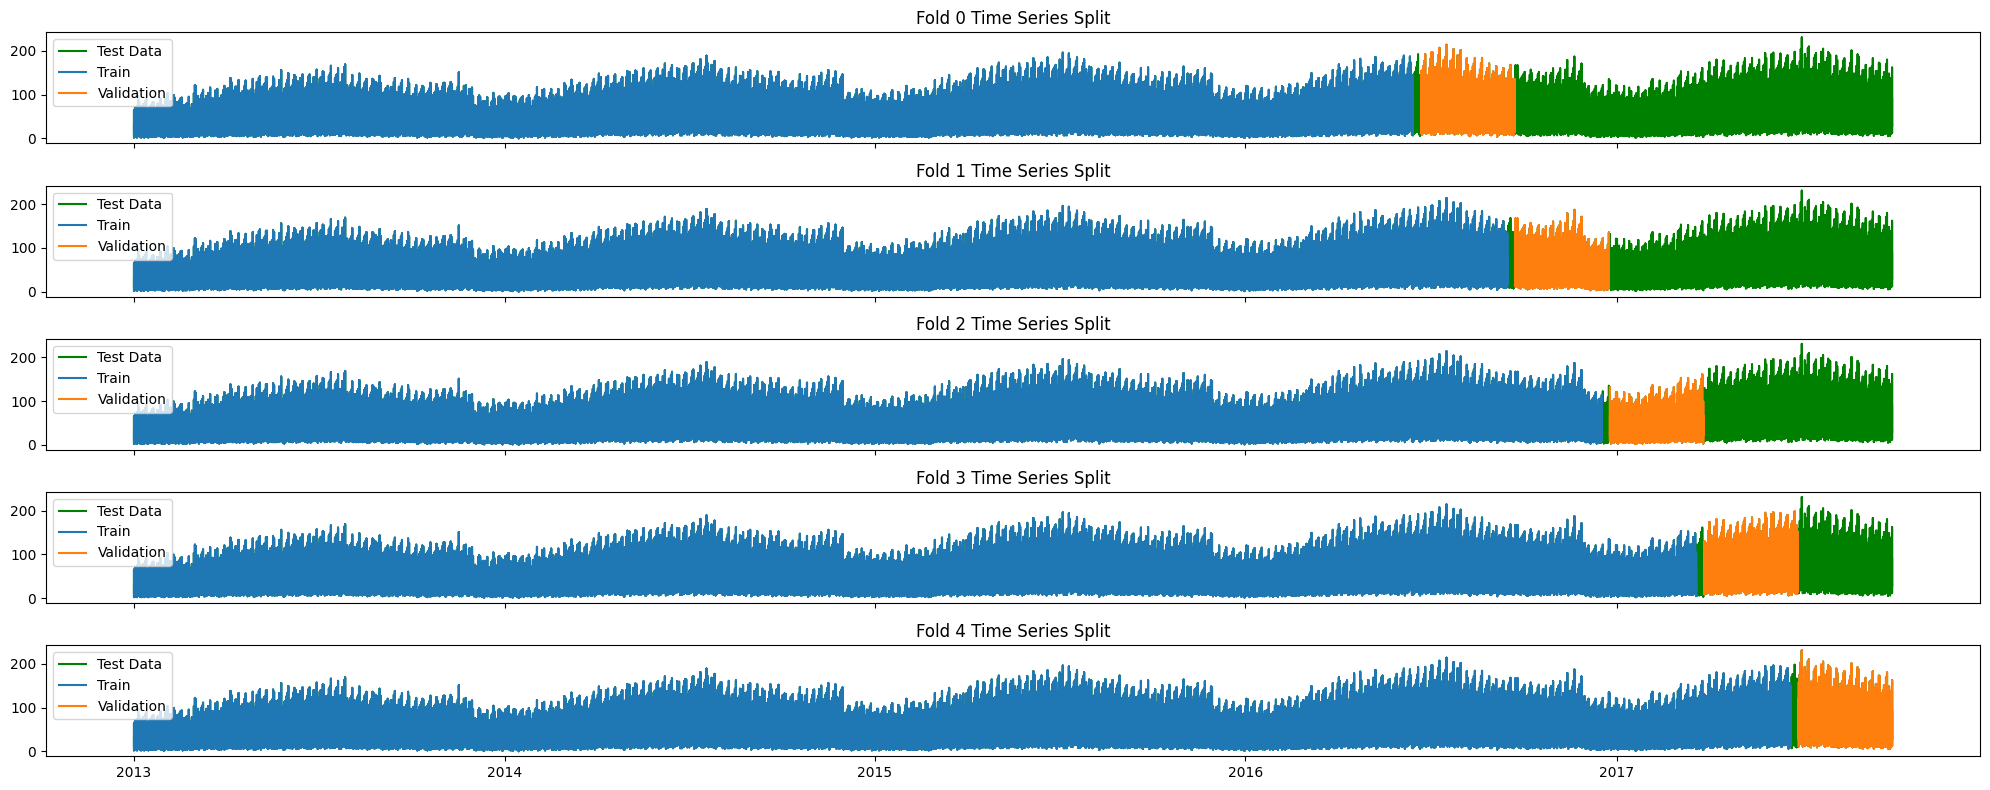

In [ ]:
time_series_cv_report(train, target=TARGET, test_size=TEST_SIZE, gap=GAP, n_splits=5)

In [ ]:
def time_series_cv(data, model, target, test_size=None, gap=0, n_splits=5, log=False, verbose=False, display_score=True):
    '''
    Performs time series cross-validation for the specified model and data.

    Args:
    data (pandas.DataFrame): The time series data.
    model : The machine learning model to be used.
    target (str): The target variable.
    test_size (int, optional): The size of the test set. Defaults to None.
    gap (int, optional): The gap between train and test sets. Defaults to 0.
    n_splits (int, optional): Number of splits for cross-validation. Defaults to 5.
    log (bool, optional): Whether a log-transformation was applied to the target variable. Defaults to False.
    verbose (bool, optional): Whether to display verbose output. Defaults to False.
    display_score (bool, optional): Whether to display the cross-validation score. Defaults to True.

    Raises:
    Exception: An error occurred during the time series cross-validation process.
    '''
    try:
        # Get sklearn TimeSeriesSplit object to obtain train and validation chronological indexes at each fold.
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap)

        scores = []
        for fold, (train_index, val_index) in enumerate(tscv.split(data)):
            # Obtain train and validation data at fold k.
            train = data.iloc[train_index]
            val = data.iloc[val_index]

            # Obtain predictor and target train and validation sets.
            X_train = train.drop(columns=[target])
            y_train = train[target].copy()
            X_val = val.drop(columns=[target])
            y_val = val[target].copy()

            # Fit the model to the training data.
            model.fit(X_train, y_train)

            # Predict on validation data.
            y_pred = model.predict(X_val)

            # Obtain the validation score at fold k.
            if log:
                score = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))
            else:
                score = np.sqrt(mean_squared_error(y_val, y_pred))

            scores.append(score)

            # Print the results and returning scores array.
            if verbose:
                print('-'*40)
                print(f'Fold {fold}')
                print(f'Score (RMSE) = {round(score, 4)}')

        if not display_score:
            return scores

        print('-'*60)
        print(f"{type(model).__name__}'s time series cross-validation results:")
        print(f'Average validation score = {round(np.mean(scores), 4)}')
        print(f'Standard deviation = {round(np.std(scores), 4)}')

        return scores

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

## Baseline Model with Dummy Regressor Model

In [ ]:
train_data, test_data = time_series_split(df_date, CUTOFF_DATE)
scores = time_series_cv(train_data, DummyRegressor(strategy='mean'), TARGET, TEST_SIZE, GAP, n_splits=5)

------------------------------------------------------------
DummyRegressor's time series cross-validation results:
Average validation score = 32.8972
Standard deviation = 5.6701


## Baseline LightGBM Model

In [ ]:
train_data, test_data = time_series_split(df_date, CUTOFF_DATE)
scores = time_series_cv(train_data, LGBMRegressor(verbose=1, force_row_wise=True), TARGET, TEST_SIZE, GAP, n_splits=5)

[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 630500, number of used features: 15
[LightGBM] [Info] Start training from score 49.153749
[LightGBM] [Info] Total Bins 440
[LightGBM] [Info] Number of data points in the train set: 677000, number of used features: 15
[LightGBM] [Info] Start training from score 50.372344
[LightGBM] [Info] Total Bins 440
[LightGBM] [Info] Number of data points in the train set: 723500, number of used features: 15
[LightGBM] [Info] Start training from score 50.688896
[LightGBM] [Info] Total Bins 440
[LightGBM] [Info] Number of data points in the train set: 770000, number of used features: 15
[LightGBM] [Info] Start training from score 50.314910
[LightGBM] [Info] Total Bins 440
[LightGBM] [Info] Number of data points in the train set: 816500, number of used features: 15
[LightGBM] [Info] Start training from score 51.116029
------------------------------------------------------------
LGBMRegressor's time series cross-

## Log Transformation and Lag Features LightGBM Model

In [ ]:
train_data, test_data = time_series_split(df_lag_log, CUTOFF_DATE)
scores = time_series_cv(train_data, LGBMRegressor(verbose=1, force_row_wise=True), TARGET, TEST_SIZE, GAP, n_splits=5, log=True)

[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 630500, number of used features: 12
[LightGBM] [Info] Start training from score 3.762217
[LightGBM] [Info] Total Bins 1781
[LightGBM] [Info] Number of data points in the train set: 677000, number of used features: 12
[LightGBM] [Info] Start training from score 3.784361
[LightGBM] [Info] Total Bins 1851
[LightGBM] [Info] Number of data points in the train set: 723500, number of used features: 12
[LightGBM] [Info] Start training from score 3.791340
[LightGBM] [Info] Total Bins 1854
[LightGBM] [Info] Number of data points in the train set: 770000, number of used features: 12
[LightGBM] [Info] Start training from score 3.784553
[LightGBM] [Info] Total Bins 1855
[LightGBM] [Info] Number of data points in the train set: 816500, number of used features: 12
[LightGBM] [Info] Start training from score 3.799479
------------------------------------------------------------
LGBMRegressor's time series cross-

## Log Transformation and Rolling Features LightGBM Model

In [ ]:
train_data, test_data = time_series_split(df_roll_log, CUTOFF_DATE)
scores = time_series_cv(train_data, LGBMRegressor(verbose=1, force_row_wise=True), TARGET, TEST_SIZE, GAP, n_splits=5, log=True)

[LightGBM] [Info] Total Bins 2288
[LightGBM] [Info] Number of data points in the train set: 630500, number of used features: 14
[LightGBM] [Info] Start training from score 3.762217
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 677000, number of used features: 14
[LightGBM] [Info] Start training from score 3.784361
[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 723500, number of used features: 14
[LightGBM] [Info] Start training from score 3.791340
[LightGBM] [Info] Total Bins 2339
[LightGBM] [Info] Number of data points in the train set: 770000, number of used features: 14
[LightGBM] [Info] Start training from score 3.784553
[LightGBM] [Info] Total Bins 2340
[LightGBM] [Info] Number of data points in the train set: 816500, number of used features: 14
[LightGBM] [Info] Start training from score 3.799479
------------------------------------------------------------
LGBMRegressor's time series cross-

## Log Transformation and Exponentially Mean Weighted Features LightGBM Features

In [ ]:
train_data, test_data = time_series_split(df_ewm_log, CUTOFF_DATE)
scores = time_series_cv(train_data, LGBMRegressor(verbose=1, force_row_wise=True), TARGET, TEST_SIZE, GAP, n_splits=5, log=True)

[LightGBM] [Info] Total Bins 12812
[LightGBM] [Info] Number of data points in the train set: 630500, number of used features: 52
[LightGBM] [Info] Start training from score 3.762217
[LightGBM] [Info] Total Bins 12812
[LightGBM] [Info] Number of data points in the train set: 677000, number of used features: 52
[LightGBM] [Info] Start training from score 3.784361
[LightGBM] [Info] Total Bins 12812
[LightGBM] [Info] Number of data points in the train set: 723500, number of used features: 52
[LightGBM] [Info] Start training from score 3.791340
[LightGBM] [Info] Total Bins 12812
[LightGBM] [Info] Number of data points in the train set: 770000, number of used features: 52
[LightGBM] [Info] Start training from score 3.784553
[LightGBM] [Info] Total Bins 12812
[LightGBM] [Info] Number of data points in the train set: 816500, number of used features: 52
[LightGBM] [Info] Start training from score 3.799479
------------------------------------------------------------
LGBMRegressor's time series c